In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [85]:
### Baseline
def generate_results(runs, file, model):
    df_all = pd.DataFrame()
    for i in range(runs):
        df = pd.read_csv(file + 'model_' + str(model) + '_run_' + str(i+1) +'.csv')    
        df_all = pd.concat([df_all, df])
    return df_all

file_base = 'different_population/'

baseline = generate_results(10, file_base, 1)
baseline = baseline.groupby(['time', 'infection_status', 'risk_group']).mean().reset_index()


In [86]:
def process_data(file, work_pro_list):
    df_list = []  # Initialize an empty list to store the dataframes

    for work_pro in work_pro_list:
        df = generate_results(10, file, work_pro)
        df = df.groupby(['time', 'infection_status', 'risk_group']).mean().reset_index()
        df['work_pro'] = work_pro

        df_list.append(df)  # Append each dataframe to the list

    df_concat = pd.concat(df_list)  # Concatenate all the dataframes in the list

    return df_concat

In [87]:
risk_group_mapping = pd.DataFrame(columns=['Risk_group', 'Decision', 'State_variable_VUL', 'State_variable_SES'])
risk_group_mapping['Risk_group'] = ['g0-00', 'g0-01', 'g0-10', 'g0-11', 'g1-00', 'g1-01', 'g1-10', 'g1-11']
risk_group_mapping['Decision'] = ['not-work', 'not-work', 'not-work', 'not-work',
                                  'work', 'work', 'work', 'work']
risk_group_mapping['State_variable_VUL'] = ['not-vulnerable', 'not-vulnerable', 'vulnerable', 'vulnerable',
                                            'not-vulnerable', 'not-vulnerable', 'vulnerable', 'vulnerable']
risk_group_mapping['State_variable_SES'] = ['high-SES', 'low-SES', 'high-SES', 'low-SES',
                                            'high-SES', 'low-SES', 'high-SES', 'low-SES']
risk_group_mapping['Wage'] = [262, 98, 262, 98, 262, 98, 262, 98]
risk_group_mapping['consumption'] = [66, 15, 66, 15, 66, 15, 66, 15]

In [88]:
baseline = baseline[(baseline['time'] <=80)&(baseline['time'] >= 20)].reset_index().drop(columns = ['index'])
baseline_count = baseline.groupby(['risk_group']).sum().drop(columns = ['time']).reset_index()
baseline_count['%'] = baseline_count['count']/(4000*60)
baseline_count = baseline_count[baseline_count['risk_group'].str[:2] == 'g1'].reset_index().drop(columns = ['index'])
baseline_count['Risk_group'] = baseline_count['risk_group'].str[-2:]
baseline_count = baseline_count.drop(columns = ['infection_status'])

In [89]:
day_start = 20
day_end = 80

baseline_LSES_work = 0.8
baseline_HSES_work = 0.71

df_all = pd.DataFrame()

def generate_df(day_start, day_end, policy, col, df, df_all):
    for i in df[col].unique():
        for rg in ['00', '01', '10', '11']:
            average_inf = df[(df['time'] >= day_start) & (df['time'] < day_end) & \
                             (df['risk_group'].str[-2:] == rg) & (df[col] == i) & (df['infection_status'] == 'i')]['count'].sum()/(4000*(day_end-day_start))

            average_labor = df[(df['time'] >= day_start) & (df['time'] < day_end) & \
                               (df['risk_group'] == 'g1-' + rg) & (df[col] == i)]['count'].sum()/(4000*(day_end-day_start))
            # print(average_inf)
            
            if rg in ['00', '10']:
                wage = 262
                consumption = 66
                baseline_labor = 0.80
            if rg in ['01', '11']:
                wage = 98
                consumption = 15
                baseline_labor = 0.87

            baseline_income = baseline_labor*wage + (1-baseline_labor)*consumption

            if policy == 'forced_behavior':
                average_income = average_labor*wage + (1-average_labor)*consumption

            if policy == 'unconditional':
                average_income = average_labor*wage + (1-average_labor)*consumption + i

            if policy == 'conditional':
                average_income = average_labor*wage + (1-average_labor)*(consumption + i)

            if policy == 'paid_sick_leave':
                average_income = average_labor*wage + (1-average_labor)*consumption + average_inf*i
                

            dic = {
            'Policy_type' : policy,
            'Average_inf' : average_inf,
            'Average_labor' : average_labor,
            'Average_income' : average_income,
            'Risk_group' : rg,
            'Payment' : i,
            'Baseline_income': baseline_income,
            # 'Cost_per_capita' : i*day,
            # 'total_payment_per_capita_rg' : i*day,
            'wage' : wage,
            'consumption': consumption
             }
            
            df_all = pd.concat([df_all, pd.DataFrame([dic])], ignore_index = True)
    return df_all

In [90]:
file_fb = 'policy/forced_behavior/'
work_pro_list = [0.3, 0.4, 0.5, 0.6, 0.7]
df_fb = process_data(file_fb, work_pro_list)
df_fb = df_fb.drop(columns = ['Unnamed: 0']).reset_index().drop(columns = ['index'])

file_uncon = 'policy/unconditional/'
pay_uncon = [18, 36, 54, 72, 90]
df_uc = process_data(file_uncon, pay_uncon)
df_uc = df_uc.drop(columns = ['Unnamed: 0']).reset_index().drop(columns = ['index'])

file_con = 'policy/conditional/'
pay_con = [18, 36, 54, 72, 90]
df_c = process_data(file_con, pay_con)
df_c = df_c.drop(columns = ['Unnamed: 0']).reset_index().drop(columns = ['index'])

file_ps = 'policy/paid_sick_leave/'
pay_ps = [18, 36, 54, 72, 90]
df_ps = process_data(file_ps, pay_ps)
df_ps = df_ps.drop(columns = ['Unnamed: 0']).reset_index().drop(columns = ['index'])

df_all = pd.DataFrame()
df_all = generate_df(day_start, day_end, 'unconditional', 'work_pro', df_uc, df_all)
df_all = generate_df(day_start, day_end, 'conditional', 'work_pro', df_c, df_all)
df_all = generate_df(day_start, day_end, 'paid_sick_leave', 'work_pro', df_ps, df_all)
df_all = generate_df(day_start, day_end, 'forced_behavior', 'work_pro', df_fb, df_all)


In [91]:
df_pop = pd.read_pickle('policy/policy_evaluation.pkl')
df_all = df_all.merge(df_pop[['Policy_type', 'Payment', 'income_cost', 'subsidy_cost', 'individual_cost',
       'total_cost']])
df_all['Relative_income'] = df_all['Average_income']/df_all['Baseline_income']
df_all['Average_inf'] = df_all['Average_inf']*100
df_all['Average_labor'] = df_all['Average_labor']*100

In [92]:
### Generate income loss relative to baseline
baseline_LSES_work = 0.8
baseline_HSES_work = 0.71
baseline_income = baseline_LSES_work*98 + (1-baseline_LSES_work)*15 + \
baseline_HSES_work*262 + (1-baseline_HSES_work)*66

baseline_income_LSES = baseline_LSES_work*98 + (1-baseline_LSES_work)*15
baseline_income_HSES = baseline_HSES_work*262 + (1-baseline_HSES_work)*66

/var/folders/fg/qtvw7sp54r91rm2skfzzb8ww0000gn/T/ipykernel_32324/991649263.py:139: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2, 0].set_xticklabels(sticks)


Text(0.05, 0.9, 'd3')

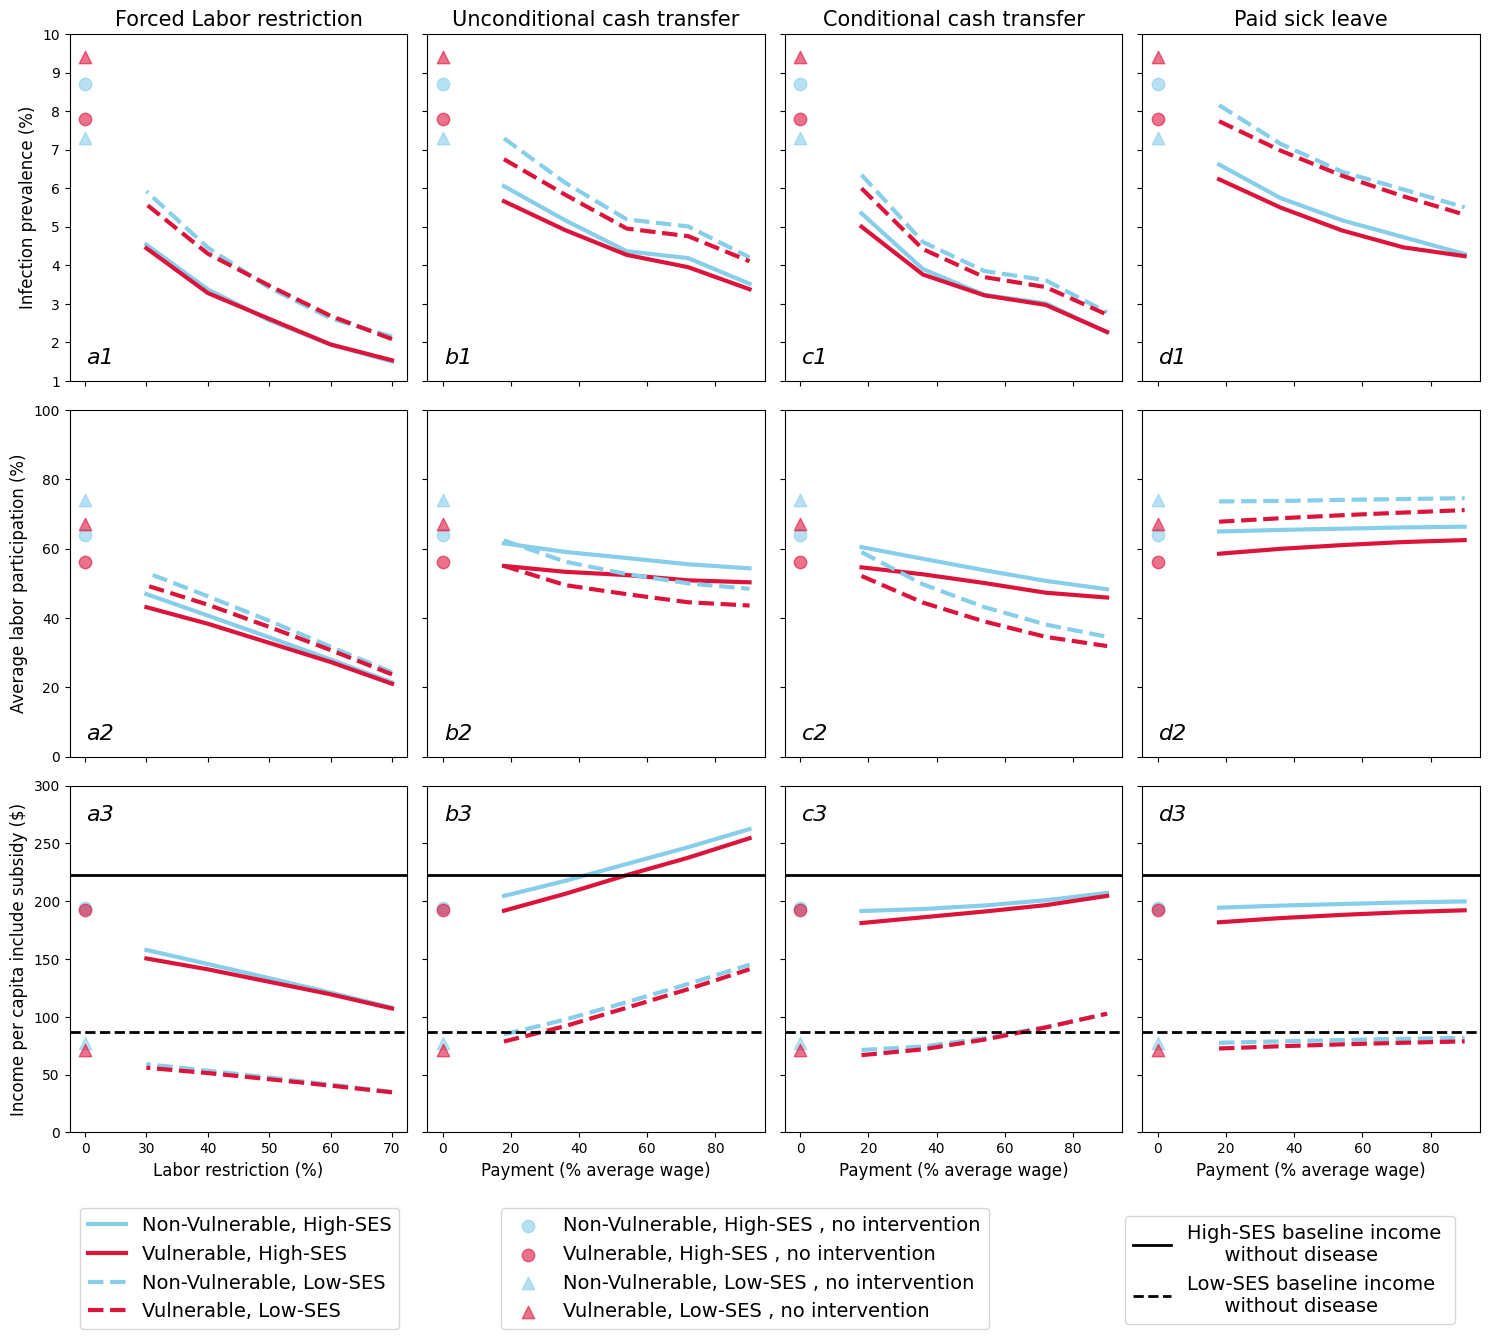

In [96]:
fig, axs = plt.subplots(3, 4, figsize = (15, 12))

# color_HSES_V = '#FFCFDF'
# color_HSES_NV = '#FFD4B2'
# color_LSES_V = 'skyblue'
# color_LSES_NV = '#CDE990'

color_HSES_V = 'crimson'
color_HSES_NV = 'skyblue'
color_LSES_V = 'crimson'
color_LSES_NV = 'skyblue'

dotsize = 80
linewidth = 3
alpha = 0.6

colors = [color_HSES_NV, color_HSES_V, color_LSES_NV, color_LSES_V]
RGs = ['00', '10', '01', '11']

# peak =[7.8, 7.3, 9.4, 8.7]
# work = [64, 56, 74, 67]
# income = [.86, .79, .88, .81]

peak =[8.7, 7.8, 7.3, 9.4]
# work = [67, 64, 56, 74]
work = [64, 56, 74, 67]
income = [194.475795, 192.262007, 77.779125, 71.619418]


lines = ['-', '-', '--', '--']

policy2 = 'unconditional'
policy3 = 'conditional'
policy4 = 'paid_sick_leave'
policy1 = 'forced_behavior'

markers = ['o', 'o', '^', '^']

labels = ['Non-Vulnerable, High-SES', 'Vulnerable, High-SES', 'Non-Vulnerable, Low-SES', 'Vulnerable, Low-SES']


for i in range(len(colors)):
    axs[0, 0].plot((1 - df_all[(df_all['Policy_type'] == policy1)&(df_all['Risk_group'] == RGs[i])]['Payment'])*100,
            df_all[(df_all['Policy_type'] == policy1)&(df_all['Risk_group'] == RGs[i])]['Average_inf'], 
            color = colors[i], label = labels[i], linestyle = lines[i], linewidth = linewidth)
    
    axs[0, 1].plot(df_all[(df_all['Policy_type'] == policy2)&(df_all['Risk_group'] == RGs[i])]['Payment'],
            df_all[(df_all['Policy_type'] == policy2)&(df_all['Risk_group'] == RGs[i])]['Average_inf'], 
            color = colors[i], linestyle = lines[i], linewidth = linewidth)
    
    axs[0, 2].plot(df_all[(df_all['Policy_type'] == policy3)&(df_all['Risk_group'] == RGs[i])]['Payment'],
            df_all[(df_all['Policy_type'] == policy3)&(df_all['Risk_group'] == RGs[i])]['Average_inf'], 
            color = colors[i], linestyle = lines[i], linewidth = linewidth)
    axs[0, 3].plot((df_all[(df_all['Policy_type'] == policy4)&(df_all['Risk_group'] == RGs[i])]['Payment']),
                df_all[(df_all['Policy_type'] == policy4)&(df_all['Risk_group'] == RGs[i])]['Average_inf'], 
                color = colors[i], linestyle = lines[i], linewidth = linewidth)
    
    axs[1, 0].plot((1 - df_all[(df_all['Policy_type'] == policy1)&(df_all['Risk_group'] == RGs[i])]['Payment'])*100,
            df_all[(df_all['Policy_type'] == policy1)&(df_all['Risk_group'] == RGs[i])]['Average_labor'], 
            color = colors[i], linestyle = lines[i], linewidth = linewidth)
    axs[1, 1].plot(df_all[(df_all['Policy_type'] == policy2)&(df_all['Risk_group'] == RGs[i])]['Payment'],
            df_all[(df_all['Policy_type'] == policy2)&(df_all['Risk_group'] == RGs[i])]['Average_labor'], 
            color = colors[i], linestyle = lines[i], linewidth = linewidth)
    axs[1, 2].plot(df_all[(df_all['Policy_type'] == policy3)&(df_all['Risk_group'] == RGs[i])]['Payment'],
            df_all[(df_all['Policy_type'] == policy3)&(df_all['Risk_group'] == RGs[i])]['Average_labor'], 
            color = colors[i], linestyle = lines[i], linewidth = linewidth)
    axs[1, 3].plot((df_all[(df_all['Policy_type'] == policy4)&(df_all['Risk_group'] == RGs[i])]['Payment']),
                df_all[(df_all['Policy_type'] == policy4)&(df_all['Risk_group'] == RGs[i])]['Average_labor'], 
                color = colors[i], linestyle = lines[i], linewidth = linewidth)
    
    axs[2, 0].plot((1 - df_all[(df_all['Policy_type'] == policy1)&(df_all['Risk_group'] == RGs[i])]['Payment'])*100,
                df_all[(df_all['Policy_type'] == policy1)&(df_all['Risk_group'] == RGs[i])]['Average_income'], 
                color = colors[i], linestyle = lines[i], linewidth = linewidth)
    axs[2, 1].plot(df_all[(df_all['Policy_type'] == policy2)&(df_all['Risk_group'] == RGs[i])]['Payment'],
                df_all[(df_all['Policy_type'] == policy2)&(df_all['Risk_group'] == RGs[i])]['Average_income'], 
                color = colors[i], linestyle = lines[i], linewidth = linewidth)
    axs[2, 2].plot(df_all[(df_all['Policy_type'] == policy3)&(df_all['Risk_group'] == RGs[i])]['Payment'],
                df_all[(df_all['Policy_type'] == policy3)&(df_all['Risk_group'] == RGs[i])]['Average_income'], 
                color = colors[i], linestyle = lines[i], linewidth = linewidth)
    axs[2, 3].plot((df_all[(df_all['Policy_type'] == policy4)&(df_all['Risk_group'] == RGs[i])]['Payment']),
                df_all[(df_all['Policy_type'] == policy4)&(df_all['Risk_group'] == RGs[i])]['Average_income'], 
                color = colors[i], linestyle = lines[i], linewidth = linewidth)
    
    axs[0, 0].scatter(20, peak[i], color = colors[i], marker = markers[i], s = dotsize, alpha = alpha)
    axs[0, 1].scatter(0, peak[i], color = colors[i], marker = markers[i], s = dotsize, alpha = alpha)
    axs[0, 2].scatter(0, peak[i], color = colors[i], marker = markers[i], s = dotsize, alpha = alpha)
    axs[0, 3].scatter(0, peak[i], color = colors[i], marker = markers[i], s = dotsize, alpha = alpha)

    axs[1, 0].scatter(20, work[i], color = colors[i], marker = markers[i], s = dotsize, alpha = alpha, label = labels[i] + " , no intervention")
    axs[1, 1].scatter(0, work[i], color = colors[i], marker = markers[i], s = dotsize, alpha = alpha)
    axs[1, 2].scatter(0, work[i], color = colors[i], marker = markers[i], s = dotsize, alpha = alpha)
    axs[1, 3].scatter(0, work[i], color = colors[i], marker = markers[i], s = dotsize, alpha = alpha)

    axs[2, 0].scatter(20, income[i], color = colors[i], marker = markers[i], s = dotsize, alpha = alpha)
    axs[2, 1].scatter(0, income[i], color = colors[i], marker = markers[i], s = dotsize, alpha = alpha)
    axs[2, 2].scatter(0, income[i], color = colors[i], marker = markers[i], s = dotsize, alpha = alpha)
    axs[2, 3].scatter(0, income[i], color = colors[i], marker = markers[i], s = dotsize, alpha = alpha)
    
axs[2, 0].axhline(y=222.80, color = 'Black', linewidth = 2,
                  linestyle = '-', label = 'High-SES baseline income \n      without disease')

for i in [1, 2, 3]:
    axs[2, i].axhline(y=222.80, color = 'Black', linewidth = 2,
                  linestyle = '-')

axs[2, 0].axhline(y=87.21, color = 'Black', linewidth = 2,
                  linestyle = 'dashed', label = 'Low-SES baseline income \n      without disease')

for i in [1, 2, 3]:
    axs[2, i].axhline(y=87.21, color = 'Black', linewidth = 2,
                  linestyle = 'dashed')

    
for i in [0, 1, 2, 3]:
    axs[0, i].set_ylim([1, 10])

for i in [0, 1, 2, 3]:
    axs[1, i].set_ylim([0, 100])

# for i in [0, 1, 2, 3]:
#     axs[2, i].set_ylim([0.3, 1.7])

for j in [1, 2, 3]:
    axs[0,j].set_yticklabels([])
    axs[1,j].set_yticklabels([])
    axs[2,j].set_yticklabels([])

for j in [0, 1, 2, 3]:
    axs[0,j].set_xticklabels([])
    axs[1,j].set_xticklabels([])
#     axs[2,j].set_xticklabels([])

axs[0,1].set_title('Unconditional cash transfer', fontsize = 15)
axs[0,2].set_title('Conditional cash transfer', fontsize = 15)
axs[0,3].set_title('Paid sick leave', fontsize = 15)
axs[0,0].set_title('Forced Labor restriction', fontsize = 15)

sticks = ['20', '0', '30', '40', '50', '60', '70', '80']
axs[2, 0].set_xticklabels(sticks)

axs[2,1].set_xlabel('Payment (% average wage)', fontsize = 12)
axs[2,2].set_xlabel('Payment (% average wage)', fontsize = 12)
axs[2,3].set_xlabel('Payment (% average wage)', fontsize = 12)
axs[2,0].set_xlabel('Labor restriction (%)', fontsize = 12)

axs[0,0].set_ylabel('Infection prevalence (%)', fontsize = 12)
axs[1,0].set_ylabel('Average labor participation (%)', fontsize = 12)
axs[2,0].set_ylabel('Income per capita include subsidy ($)', fontsize = 12)

axs[2, 0].set_ylim([0, 300])
axs[2, 1].set_ylim([0, 300])
axs[2, 2].set_ylim([0, 300])
axs[2, 3].set_ylim([0, 300])

handles, labels = [], []

for handle, label in zip(*axs[0, 0].get_legend_handles_labels()):
    if label not in labels:  # Check to avoid duplicates
        handles.append(handle)
        labels.append(label)

for handle, label in zip(*axs[1, 0].get_legend_handles_labels()):
    if label not in labels:  # Check to avoid duplicates
        handles.append(handle)
        labels.append(label)

for handle, label in zip(*axs[2, 0].get_legend_handles_labels()):
    if label not in labels:  # Check to avoid duplicates
        handles.append(handle)
        labels.append(label)


plt.tight_layout()
fig.legend(handles[:4], labels[:4], loc='lower left', 
           bbox_to_anchor=(0.05, -0.12), fontsize = 14)
fig.legend(handles[4:8], labels[4:8], loc='lower center', 
           bbox_to_anchor=(0.5, -0.12), fontsize = 14)
fig.legend(handles[8:], labels[8:], 
           bbox_to_anchor=(0.98, -0.01), fontsize = 14)

plt.text(0.05, 0.05, "a1", transform=axs[0,0].transAxes, fontstyle = 'italic', fontsize = 16)
plt.text(0.05, 0.05, "b1", transform=axs[0,1].transAxes, fontstyle = 'italic', fontsize = 16)
plt.text(0.05, 0.05, "c1", transform=axs[0,2].transAxes, fontstyle = 'italic', fontsize = 16)
plt.text(0.05, 0.05, "d1", transform=axs[0,3].transAxes, fontstyle = 'italic', fontsize = 16)
plt.text(0.05, 0.05, "a2", transform=axs[1,0].transAxes, fontstyle = 'italic', fontsize = 16)
plt.text(0.05, 0.05, "b2", transform=axs[1,1].transAxes, fontstyle = 'italic', fontsize = 16)
plt.text(0.05, 0.05, "c2", transform=axs[1,2].transAxes, fontstyle = 'italic', fontsize = 16)
plt.text(0.05, 0.05, "d2", transform=axs[1,3].transAxes, fontstyle = 'italic', fontsize = 16)
plt.text(0.05, 0.9, "a3", transform=axs[2,0].transAxes, fontstyle = 'italic', fontsize = 16)
plt.text(0.05, 0.9, "b3", transform=axs[2,1].transAxes, fontstyle = 'italic', fontsize = 16)
plt.text(0.05, 0.9, "c3", transform=axs[2,2].transAxes, fontstyle = 'italic', fontsize = 16)
plt.text(0.05, 0.9, "d3", transform=axs[2,3].transAxes, fontstyle = 'italic', fontsize = 16)